# Multi-Season Model

This notebook demonstrates how to construct a multi-season model. The model being constructed here will vary the max vaccine uptake across seasons but keep the same uptake rate and switch point parameters across seasons.

In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# External dependency imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit

# `vaxflux` imports
from vaxflux.data import read_flu_vacc_data
from vaxflux.multilevel_model import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The data being used here is the sample dataset from `vaxflux.data.read_flu_vacc_data` function that gives cumulative doses (in millions) administered to all US adults weekly for the 2018/19 season through the 2023/24 season. This dataset needs a bit of work to convert it into a pandas DataFrame that can be used by the `vaxflux` package. As a part of this is an assumption that the national population of the US during that time was 333.3 million adults.

In [2]:
# Read in the example dataset being used
vacc_data = read_flu_vacc_data()
national_population = 333.3

# Transform this example dataset into a pandas DataFrame
vacc_df = pd.DataFrame(
    data={
        "time": vacc_data["sort_order"],
        "season": vacc_data["season"],
        "region": "National",
        "strata": "All Adults",
        "rate": vacc_data["doses"] / national_population,
    }
)
vacc_df.head()

,time,season,region,strata,rate
0,1,b'2018-2019',National,All Adults,0.001560
1,2,b'2018-2019',National,All Adults,0.009691
2,3,b'2018-2019',National,All Adults,0.030543
3,4,b'2018-2019',National,All Adults,0.059976
4,5,b'2018-2019',National,All Adults,0.112151


## The Model

Let $i = 1, \dots, N_{\mathrm{seasons}}$ then

$$ k_i \sim \mathcal{N}\left( \mu_k, \sigma_k^2 \right) $$

$$ r \sim \mathcal{N}\left( \mu_r, \sigma_r^2 \right) $$

$$ s \sim \mathcal{N}\left( \mu_s, \sigma_s^2 \right) $$

$$ \epsilon \sim \mathrm{HalfNormal}\left( \epsilon_{\mathrm{prior}} \right) $$

$$ y_i(t) \sim \mathcal{N}\left( f\left( t \vert K_i, r, s \right), \epsilon^2 \right) $$

where $K_i = \left( 1 + e^{-k_i} \right)^{-1}$ and $f(t\vert k,r,s)$ is a logistic function given by

$$ f\left( t \vert k, r ,s \right) = \frac{k}{1 + e^{-r(t - s)}}. $$


## Constructing The Model With `vaxflux`

Now to build this model using `vaxflux` the first step is to construct an `UptakeModelConfig` object that describes this model. The priors being used here are mildly informative and the choice of parameter values to use is largely informed by the `single_curve_model.ipynb` notebook. If you haven't read through that notebook yet, please take a brief moment to skim through that at least for the parameter values.

In [3]:
uptake_config = UptakeModelConfig(
    name="Multi-Season National Uptake Model",
    data=vacc_df,
    eps_prior=0.1,
    k_prior=(0.0, 2.0),
    r_prior=(0.5, 0.25),
    s_prior=(10.0, 3.0),
)

uptake_config

<vaxflux.multilevel_model.UptakeModelConfig named 'Multi-Season National Uptake Model'>

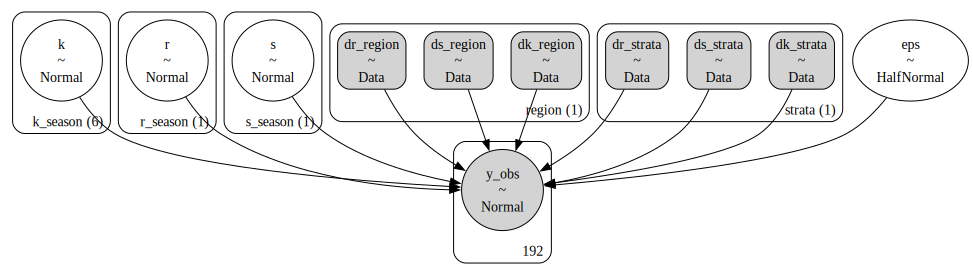

In [4]:
model = create_multilevel_model(uptake_config)
pm.model_to_graphviz(model)

Now `model` contains the model specification defined before. Unfortunately, this diagram is more complicated then it needs to be for this particular notebook because the `create_multilevel_model` function allows for specifying regional and strata specific affects to uptake. The important points to take from reading this model diagram are:

* `k` corresponds to $k_i$ and has a dimension of six correspond to one sample for each season,
* `r` and `s` correspond to $r$ and $s$ respectively and have a dimension of one,
* `eps` is the standard deviation prior for our observational model, and
* `y_obs` corresponds to the vaccine uptake seen in the data and contains 192 observations.

## Sampling The Model 

The next thing to do is to sample from the model and then evaluate how well it performs.

In [5]:
chains = 8
samples = 1000 * chains
with model:
    trace = pm.sample(
        draws=samples, tune=samples, chains=chains, cores=2, random_seed=123
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 2 jobs)
NUTS: [k, r, s, eps]


/Users/twillard/Library/Caches/pypoetry/virtualenvs/vaxflux-TxTkjOEN-py3.12/lib/python3.12/site-packages/rich/live.
py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 8 chains for 8_000 tune and 8_000 draw iterations (64_000 + 64_000 draws total) took 29 seconds.


In [6]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eps,0.014,0.001,0.012,0.015,0.0,0.0,69181.0,49635.0,1.0
k[2018-2019],0.055,0.012,0.033,0.078,0.0,0.0,75279.0,52132.0,1.0
k[2019-2020],0.065,0.012,0.042,0.087,0.0,0.0,67684.0,50819.0,1.0
k[2020-2021],0.316,0.013,0.292,0.339,0.0,0.0,65503.0,50371.0,1.0
k[2021-2022],0.092,0.012,0.069,0.114,0.0,0.0,72588.0,53196.0,1.0
k[2022-2023],-0.011,0.012,-0.034,0.011,0.0,0.0,70984.0,52893.0,1.0
k[2023-2024],-0.094,0.012,-0.116,-0.071,0.0,0.0,67117.0,51013.0,1.0
r[All Seasons],0.403,0.007,0.390,0.415,0.0,0.0,62947.0,53166.0,1.0
s[All Seasons],8.312,0.046,8.226,8.400,0.0,0.0,62831.0,52050.0,1.0


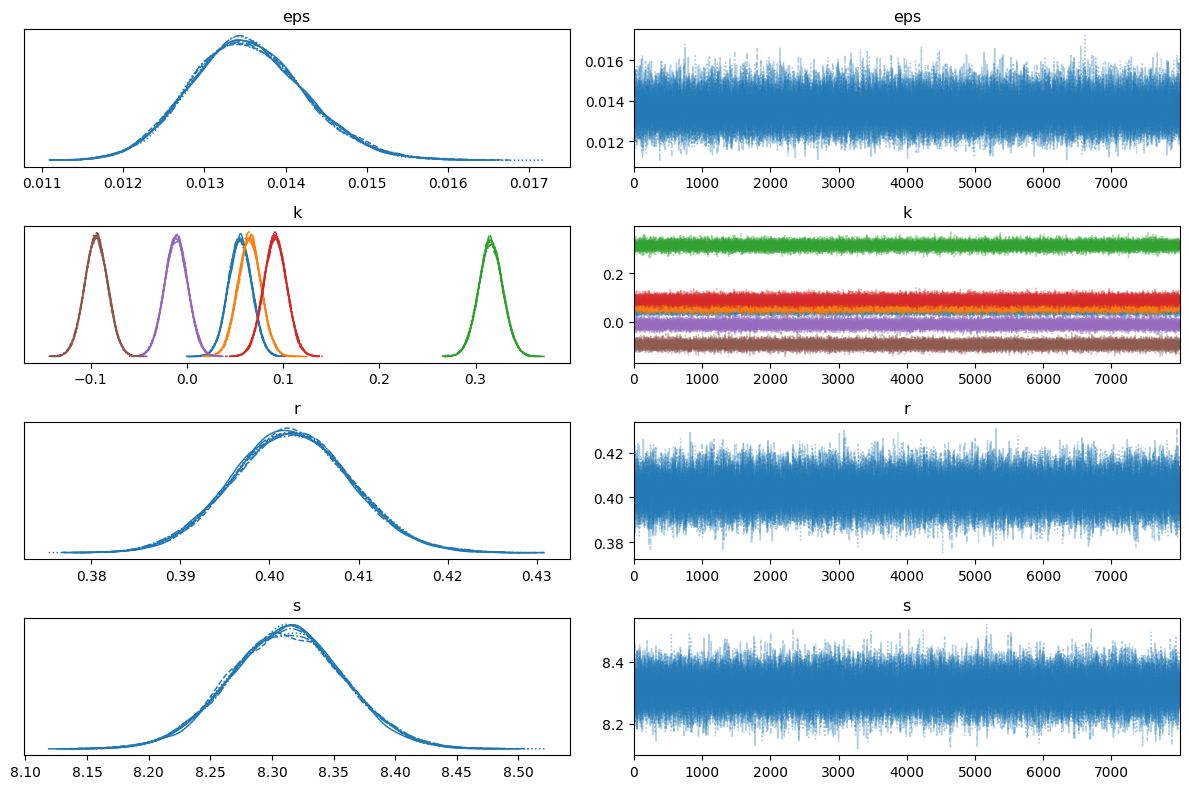

In [7]:
axes = az.plot_trace(trace, kind="trace")
plt.tight_layout()

The summary and trace plot indicate that this model has converged nicely.

In [8]:
stacked = az.extract(trace.posterior)
seasons = stacked.coords["k_season"].to_numpy().tolist()
sort_order = np.linspace(vacc_df["time"].min(), vacc_df["time"].max(), 1000)

model_dist = np.zeros((stacked.sizes["sample"], len(sort_order), len(seasons)))

for i in range(stacked.sizes["sample"]):
    for j in range(len(seasons)):
        model_dist[i, :, j] = expit(stacked.k.values[j, i]) * expit(
            stacked.r.values[0, i] * (sort_order - stacked.s.values[0, i])
        )

model_rate_quantiles = np.quantile(model_dist, [0.005, 0.5, 0.995], axis=0)
s_median = np.median(stacked.s.values)
k_median = np.median(expit(stacked.k.values), axis=1)

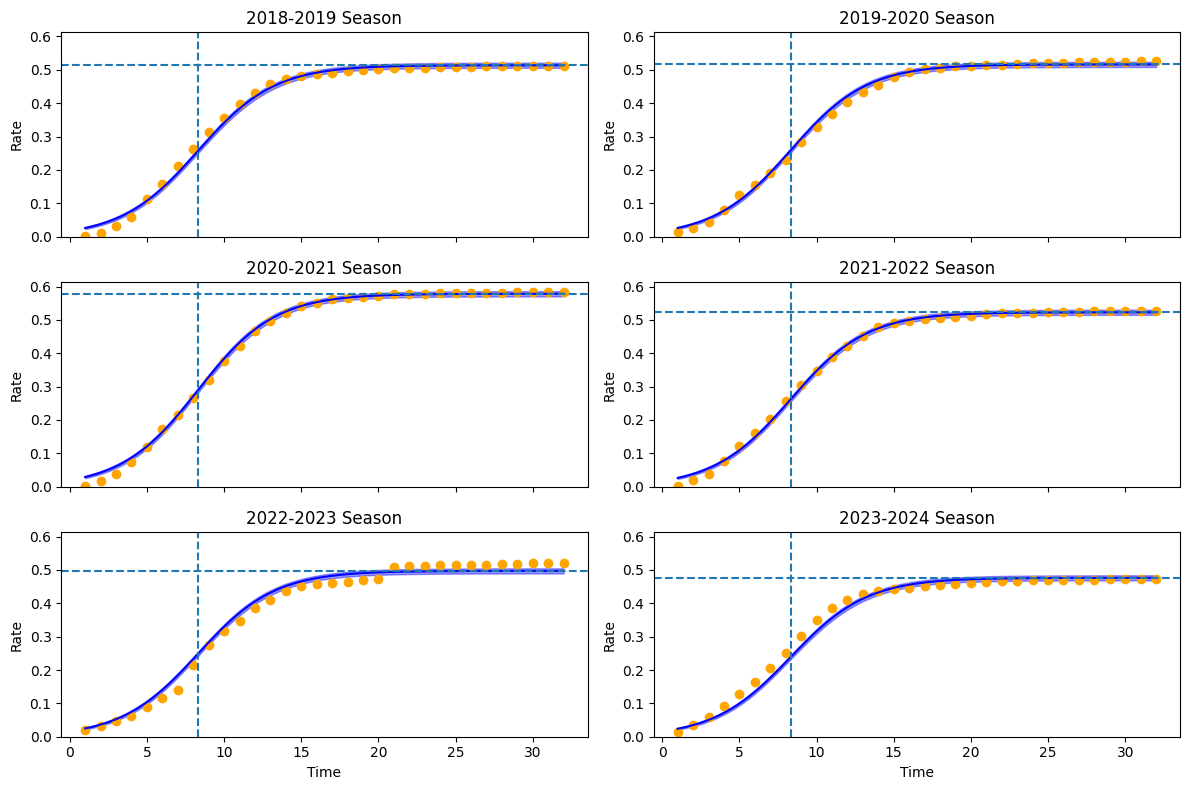

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(12, 8))
axes = axes.flatten()

ylim = (0, 1.05 * vacc_df["rate"].max().tolist())

for i, season in enumerate(seasons):
    # Plot the data
    idx = vacc_df["season"] == season.encode()
    axes[i].plot(
        vacc_df[idx]["time"],
        vacc_df[idx]["rate"],
        color="orange",
        marker="o",
        linestyle="",
    )

    # Plot the model
    axes[i].plot(sort_order, model_rate_quantiles[1, :, i], color="blue", linestyle="-")
    axes[i].fill_between(
        sort_order,
        model_rate_quantiles[0, :, i],
        model_rate_quantiles[2, :, i],
        color="blue",
        alpha=0.4,
    )
    axes[i].axvline(s_median, linestyle="--")
    axes[i].axhline(k_median[i], linestyle="--")

    # Plot formatting
    axes[i].set_ylabel("Rate")
    if i in [4, 5]:
        axes[i].set_xlabel("Time")
    axes[i].set_ylim(*ylim)
    axes[i].set_title(f"{season} Season")

fig.subplots_adjust(hspace=0)
fig.tight_layout()

Overall these model fits look good, there are some worthwhile notes though:

* There seems to be a general *over estimation* of the uptake prior to the switch point (except for the 22/23 and 23/24 seasons),
* There seems to be a slight *under estimation* of the uptake immediate after the switch point for some seasons,
* The 22/23 season has two notable discontinuities that severely impact the fit of the model, and
* The fitted max underestimates the true observed max for some seasons so the model needs to be modified such that the prior doesn't allow that to happen (or at least make it an option).